In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # normalized
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self, x):
        self.out = torch.matmul(x, self.weight)
        self.out += self.bias if self.bias else 0
        return self.out
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias else [])

In [3]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim) # record running mean and variance across dataset for inference
        self.running_var = torch.ones(dim)  
    def __call__(self, x):
        if self.training:
            xmean = torch.mean(x, axis=0) # batch mean
            xvar = torch.var(x, axis=0) # batch variance
        else: # during inference
            xmean, xvar = running_mean, running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # std
        self.out = torch.matmul(self.gamma, xhat) + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]

In [4]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [5]:
names = open("data/names.txt", 'r').read().split('\n')

In [6]:
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [7]:
len(names)

32033

In [8]:
chars = sorted(list(set(''.join(names))))
ctoi = {c:i for i, c in enumerate(chars)}
ctoi["<start>"] = 26
ctoi["<end>"] = 27
print(ctoi)
vocab_size = len(ctoi)
print(vocab_size)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '<start>': 26, '<end>': 27}
28


In [9]:
context_length = 3
X, Y = [], []
for name in names:
    name = ["<start>"] * context_length + [char for char in name] + ["<end>"] * context_length
    context = [ctoi[ch] for ch in name[:context_length]]
    for ch in name[context_length:]:
        ic = ctoi[ch]
        X.append(context)
        Y.append(ic)
        context = context[1:] + [ic]

X, Y = torch.tensor(X), torch.tensor(Y)
    

In [10]:
X[:10], Y[:10]

(tensor([[26, 26, 26],
         [26, 26,  4],
         [26,  4, 12],
         [ 4, 12, 12],
         [12, 12,  0],
         [12,  0, 27],
         [ 0, 27, 27],
         [26, 26, 26],
         [26, 26, 14],
         [26, 14, 11]]),
 tensor([ 4, 12, 12,  0, 27, 27, 27, 14, 11,  8]))

In [11]:
train_size, dev_size = int(0.8 * X.shape[0]), int(0.1 * X.shape[0])

In [12]:
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

In [13]:
X_train, Y_train = X[indices][:train_size], Y[indices][:train_size]
X_dev, Y_dev = X[indices][train_size:train_size + dev_size], Y[indices][train_size:train_size + dev_size]
X_test, Y_test = X[indices][train_size + dev_size:], Y[indices][train_size + dev_size]

In [14]:
X_train.shape[0], X_dev.shape[0], X_test.shape[0]

(233769, 29221, 29222)

In [15]:
X[:5]

tensor([[26, 26, 26],
        [26, 26,  4],
        [26,  4, 12],
        [ 4, 12, 12],
        [12, 12,  0]])

In [16]:
n_embd = 10 # embedding dimension
n_hidden = 200 # number of neurons in the hidden layer
g = torch.Generator().manual_seed(1)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * context_length, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
gamma = torch.ones((1, n_hidden))
beta= torch.zeros((1, n_hidden))
bmean_running = torch.zeros((1, n_hidden))
bstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2]
for param in parameters:
    param.requires_grad = True

In [17]:
batch_size = 32
learning_rate = 0.1
losses = []
for i in range(20000):
    # sample batch
    samp = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    x, y = X_train[samp], Y_train[samp]
    # forward & backward
    emb = C[x]
    embcat = emb.reshape(emb.shape[0], -1)
    hpreact = torch.matmul(embcat, W1) + b1
    bmeani = torch.mean(hpreact, axis=0)
    bstdi = torch.std(hpreact, axis=0)
    hpreact = gamma * (hpreact - bmeani) / bstdi + beta
    h = torch.tanh(hpreact)
    logits = torch.matmul(h, W2) + b2
    loss = F.cross_entropy(logits, y)
    losses.append(loss.item())
    with torch.no_grad():
        # momentum 0.001
        bmean_running = 0.999 * bmean_running + 0.001 * bmeani
        bstd_running = 0.999 * bstd_running + 0.001 * bstdi
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data -= learning_rate * p.grad
    if i % 1000 == 0:
        print(loss.item())

3.330103874206543
2.009866952896118
2.0117671489715576
2.041421890258789
1.6239475011825562
1.9950580596923828
1.8122663497924805
1.6025198698043823
2.295436382293701
1.5949259996414185
1.7437834739685059
1.9416346549987793
1.7765555381774902
1.5981225967407227
1.7935141324996948
1.420085072517395
1.7282326221466064
1.42689847946167
1.8953951597213745
1.5536335706710815


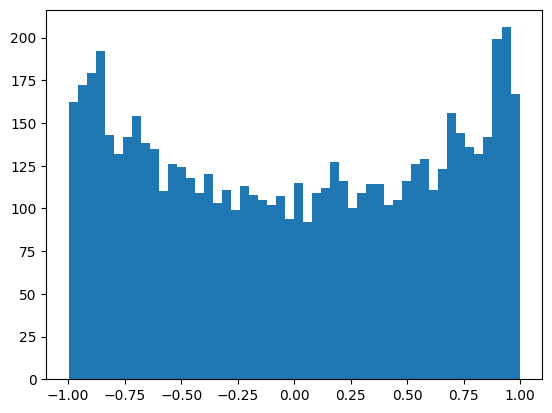

In [18]:
plt.hist(h.view(-1).tolist(), 50);

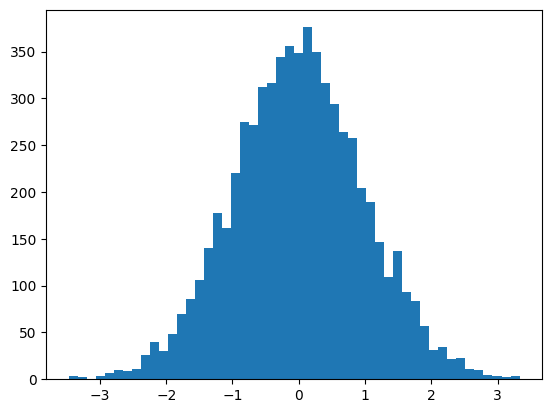

In [19]:
plt.hist(hpreact.view(-1).tolist(), 50);

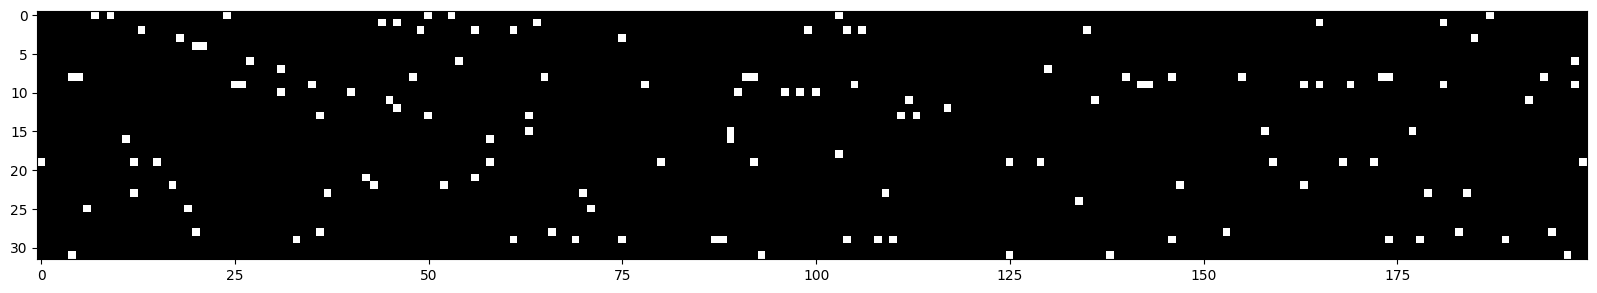

In [20]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.98, cmap="gray")